In [22]:
!pip install ultralytics

In [23]:
# import all necessary libraries
import numpy as np 
import pandas as pd 
import os
import random
from PIL import Image
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO

In [24]:
# trun off wandb reporting for this notebook
os.environ['WANDB_DISABLED'] = 'true'

In [25]:
train_img_dir = '/kaggle/input/cardetection/train/images'

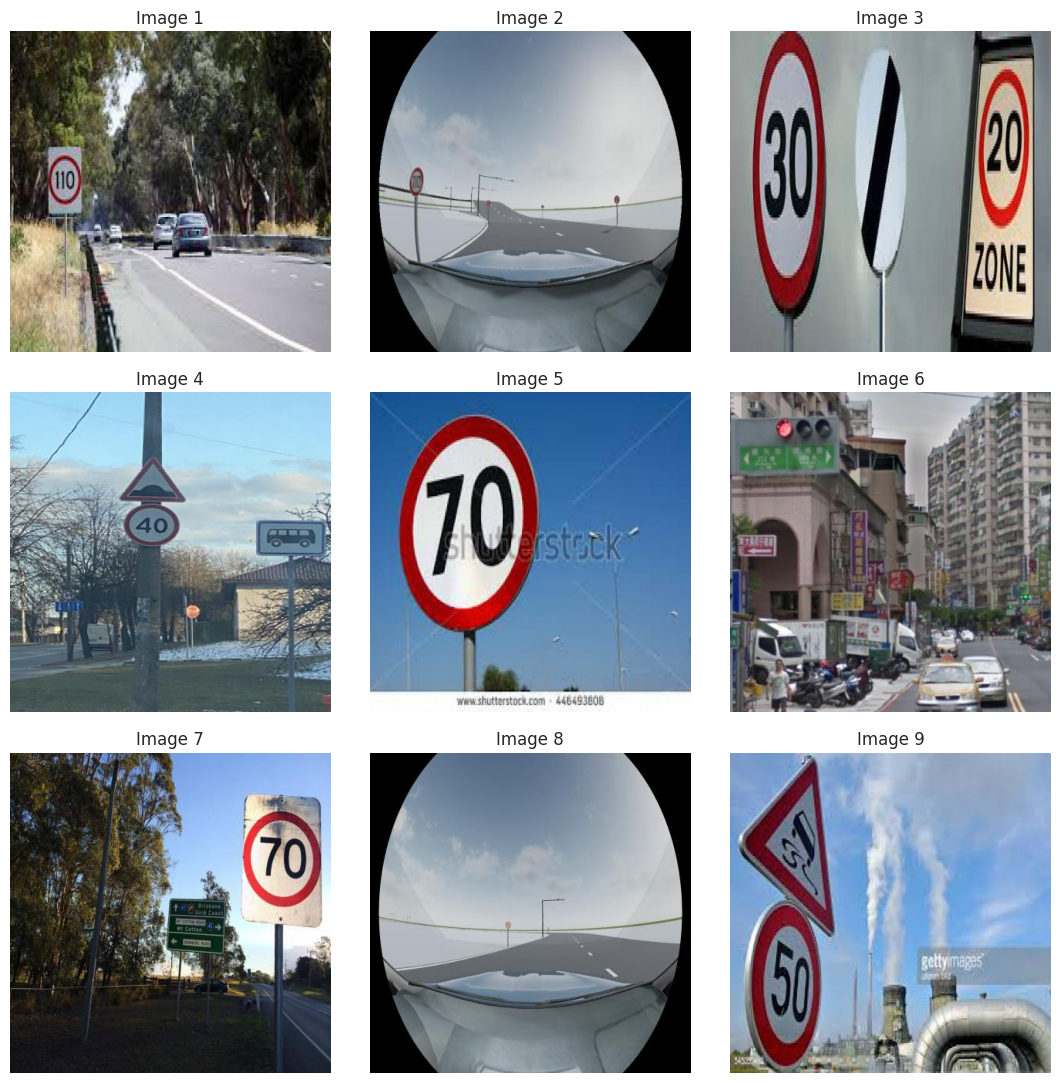

In [26]:
num_samples = 9
image_files = os.listdir(train_img_dir)
rand_imgs = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3,3, figsize = (11, 11))
for i in range(num_samples):
    image = rand_imgs[i]
    ax = axes[i // 3, i%3]
    ax.imshow(plt.imread(os.path.join(train_img_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

According to the **data.yaml** file, we have 15 different labeled classes in the dataset, shown as below:

['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

### Check out the pre-trained YOLOv8 Model

In [27]:
model = YOLO("yolov8n.pt")


image 1/1 /kaggle/input/cardetection/train/images/001264_jpg.rf.a47144d82bcd3e1e2ea46aee9d02b163.jpg: 416x416 4 cars, 6.3ms
Speed: 0.7ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/train/images/FisheyeCamera_1_00177_png.rf.5c419898b876f40e9e3808a43d49df67.jpg: 416x416 1 stop sign, 6.9ms
Speed: 1.0ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/train/images/000424_jpg.rf.79bece8e750129af99bca5825d4709aa.jpg: 416x416 (no detections), 6.4ms
Speed: 0.6ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/train/images/road875_png.rf.71bbad8e5a7500b8a0d189e54346149a.jpg: 416x416 (no detections), 6.6ms
Speed: 0.7ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/train/images/000524_jpg.rf.dc6a0ee698d3

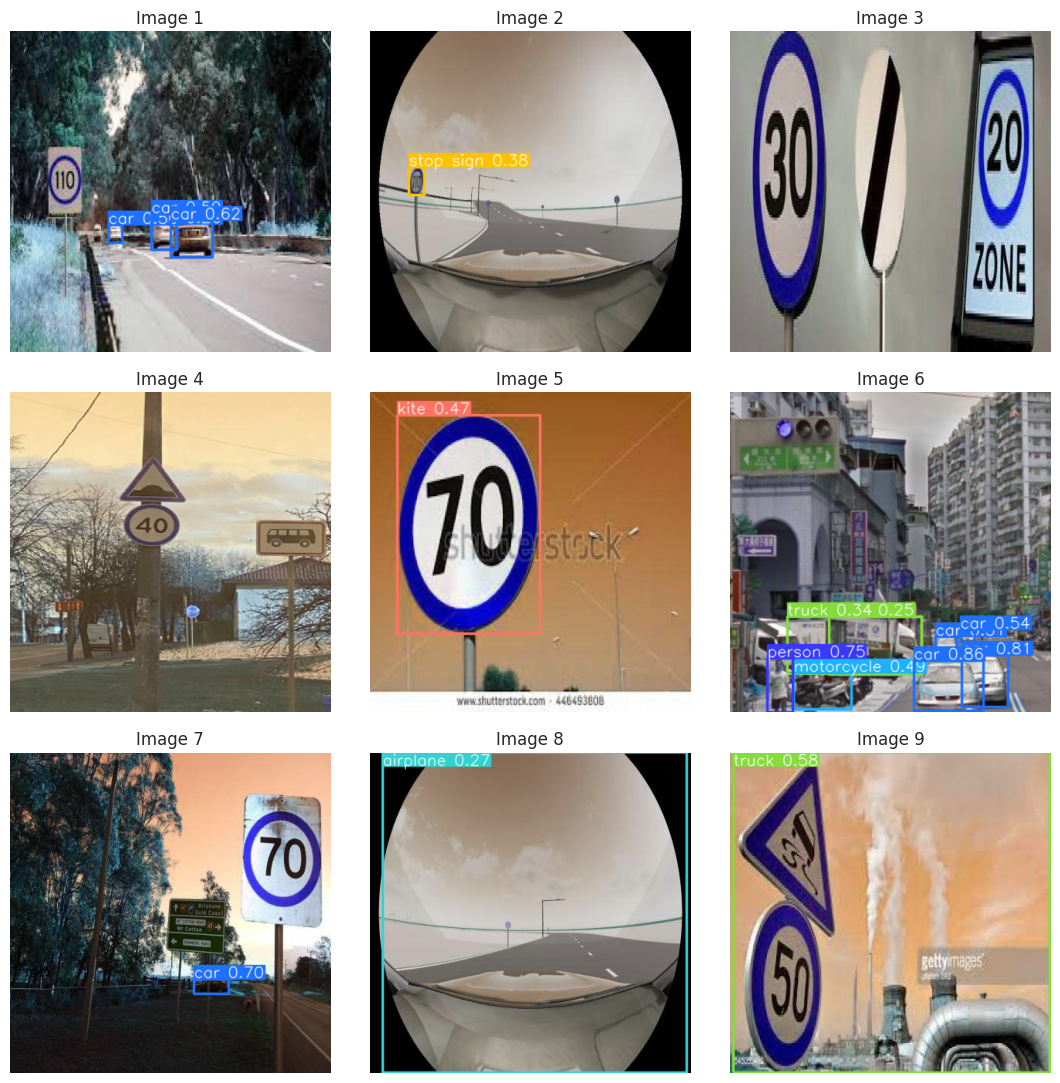

In [28]:
fig, axes = plt.subplots(3,3, figsize = (11, 11))
for i in range(num_samples):
    image = rand_imgs[i]
    ax = axes[i // 3, i%3]
    result_predict = model.predict(source = os.path.join(train_img_dir, image), imgsz = (416))
    ax.imshow(result_predict[0].plot())
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

The pre-trained YOLO does not perform very well, most of the traffic signs were not detected, or correctly labled. We will fine-tune the model using the specified dataset and see how the performance might change. 

## Fine-tune YOLOv8 with given training dataset

In [12]:
!cd /kaggle/working/

In [29]:
!yolo detect train data="/kaggle/input/cardetection/data.yaml" model=yolov8n.pt epochs=100 imgsz=416

Ultralytics YOLOv8.2.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/cardetection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

## Analyze the final model's performance

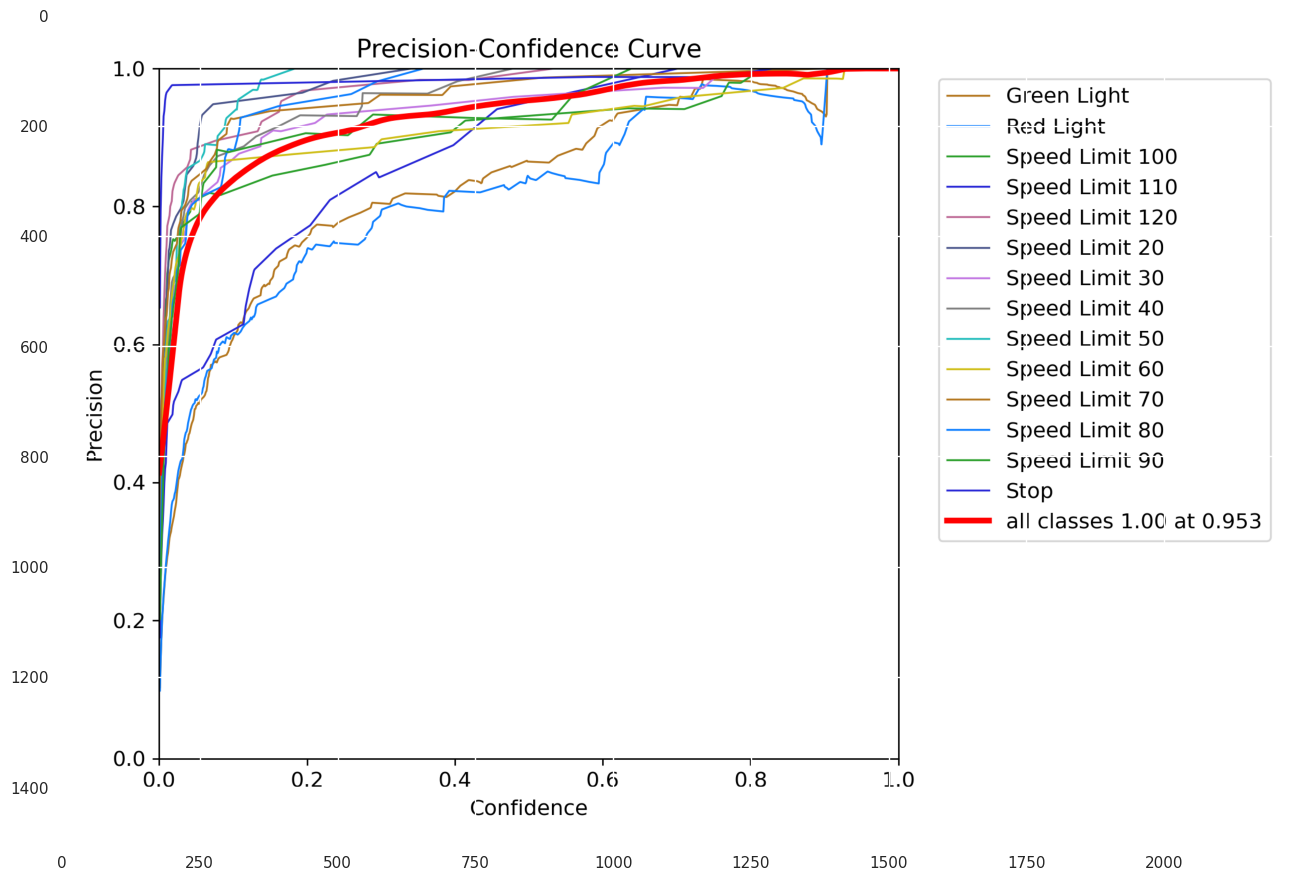

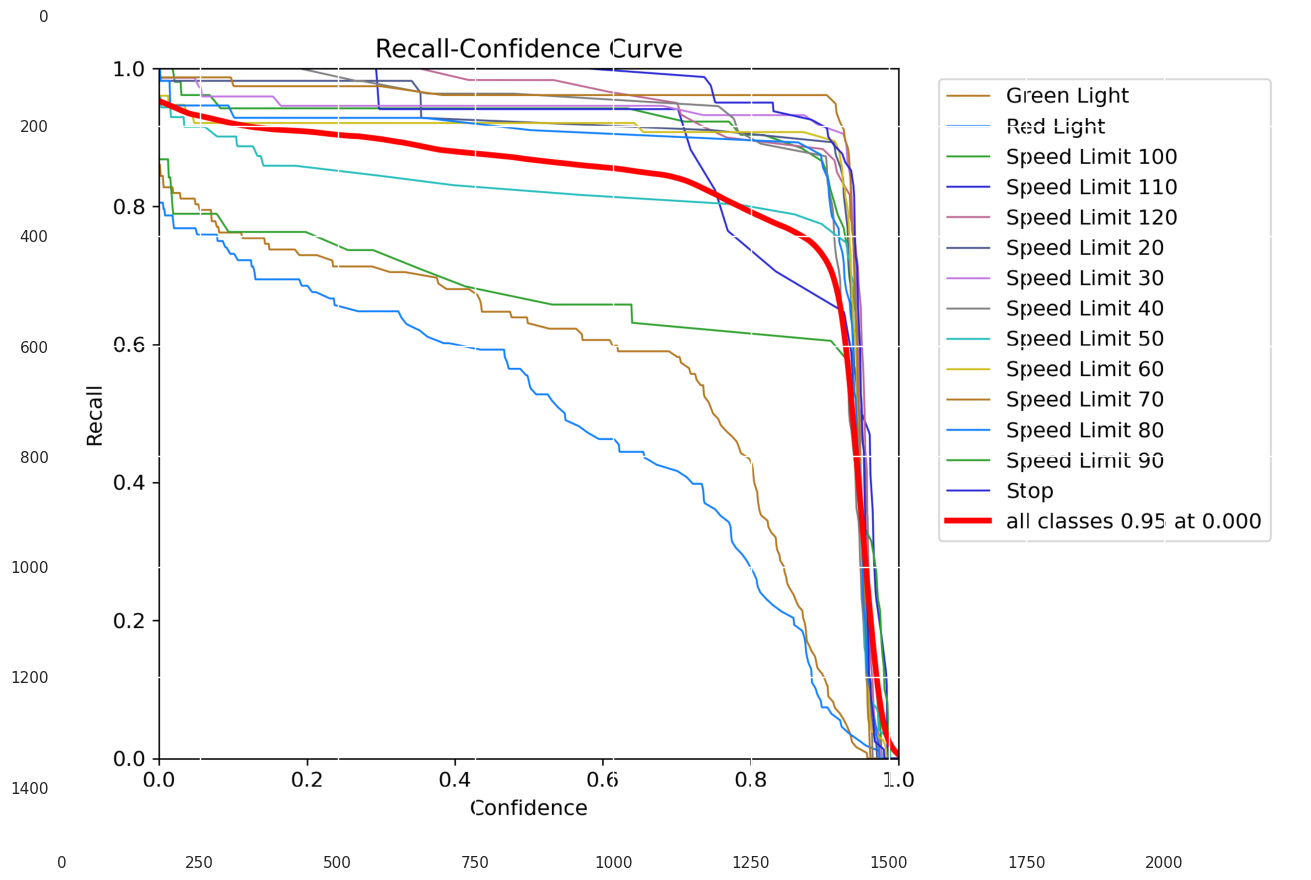

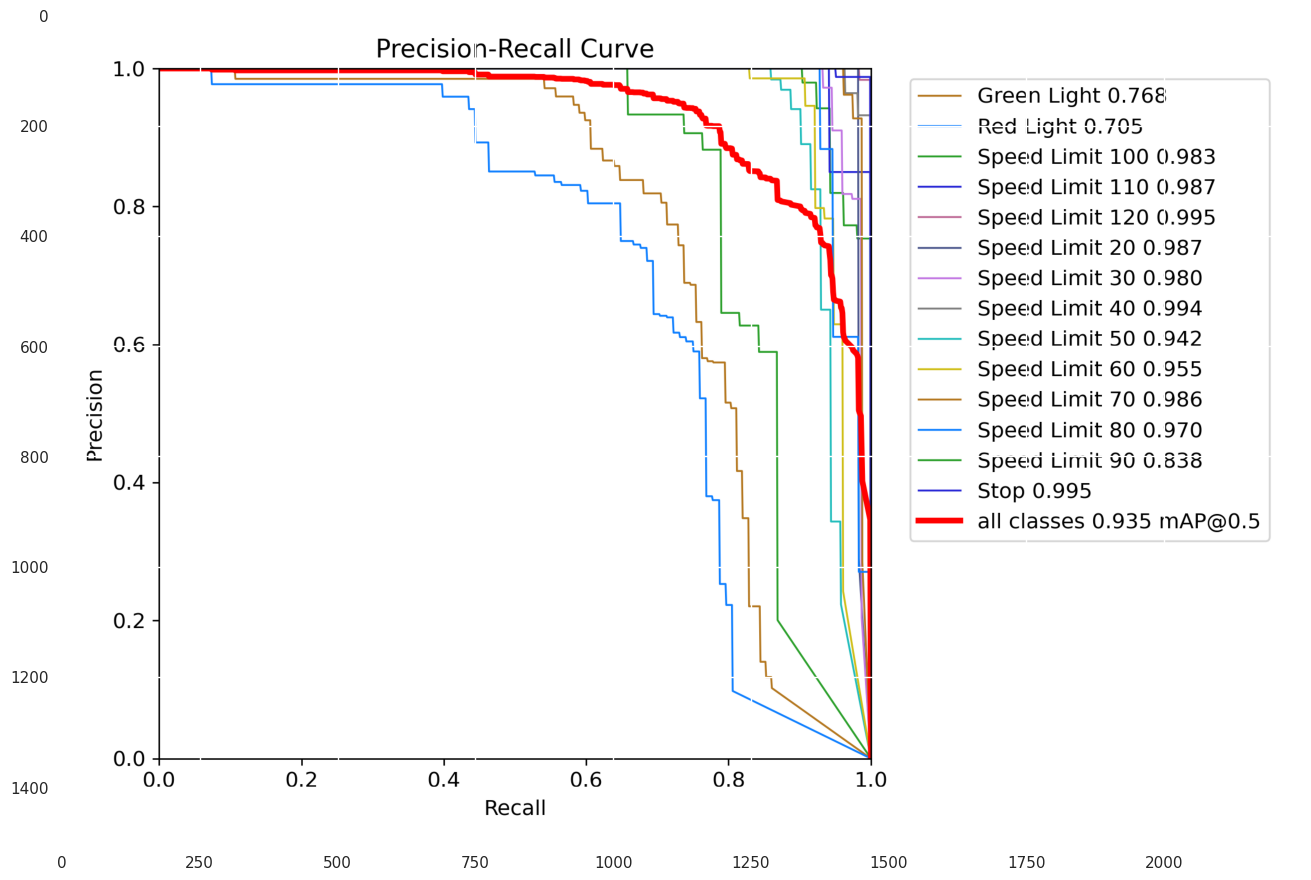

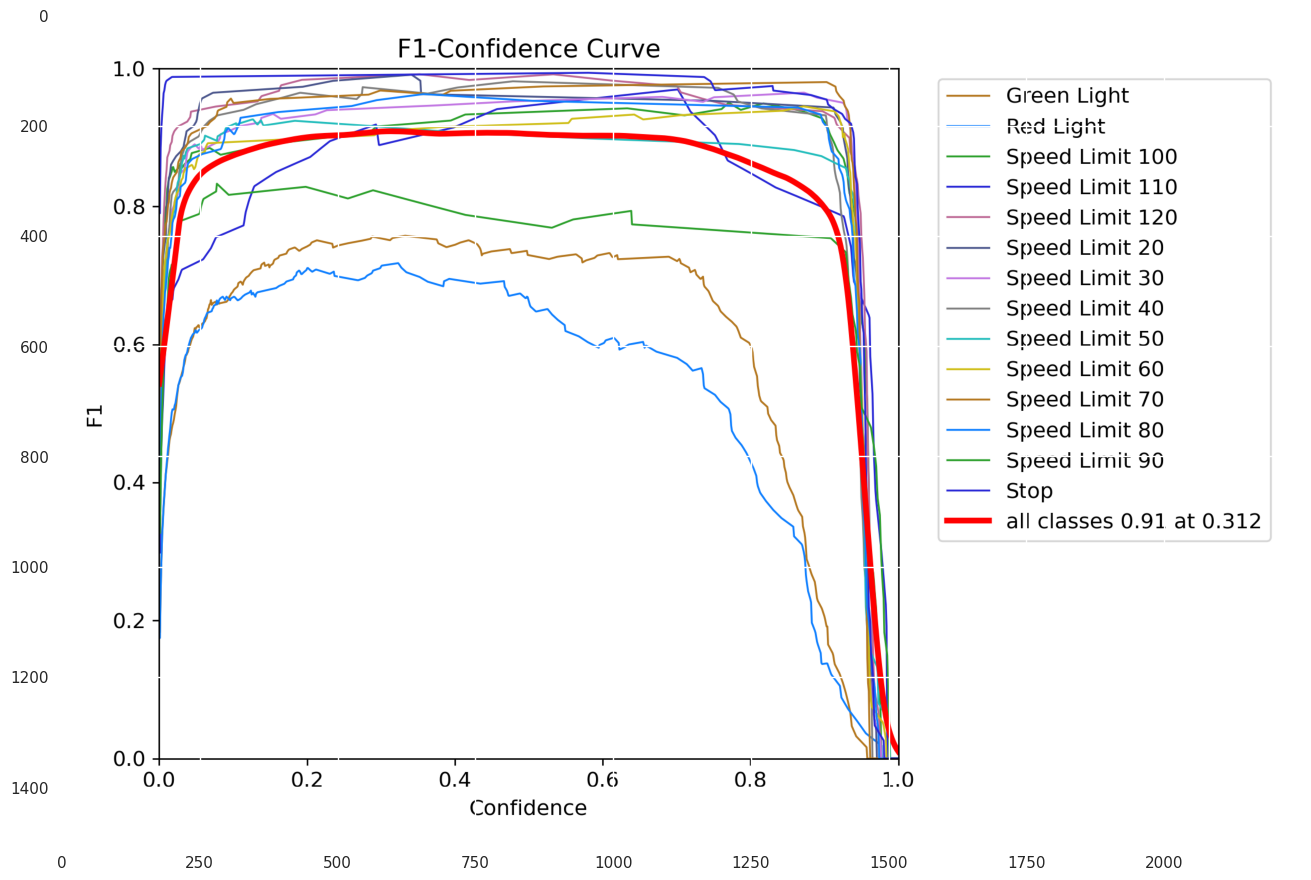

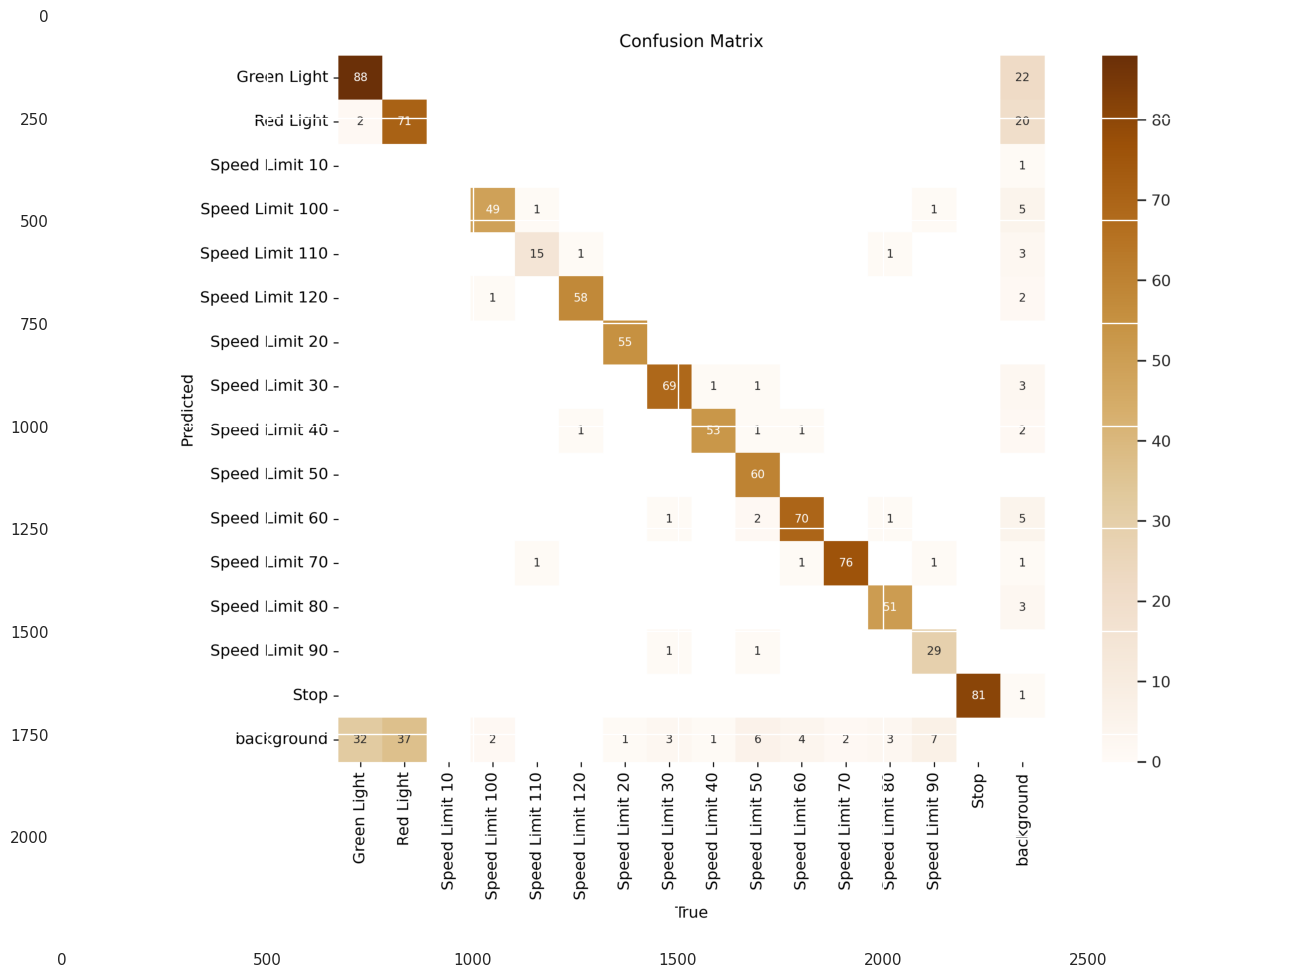

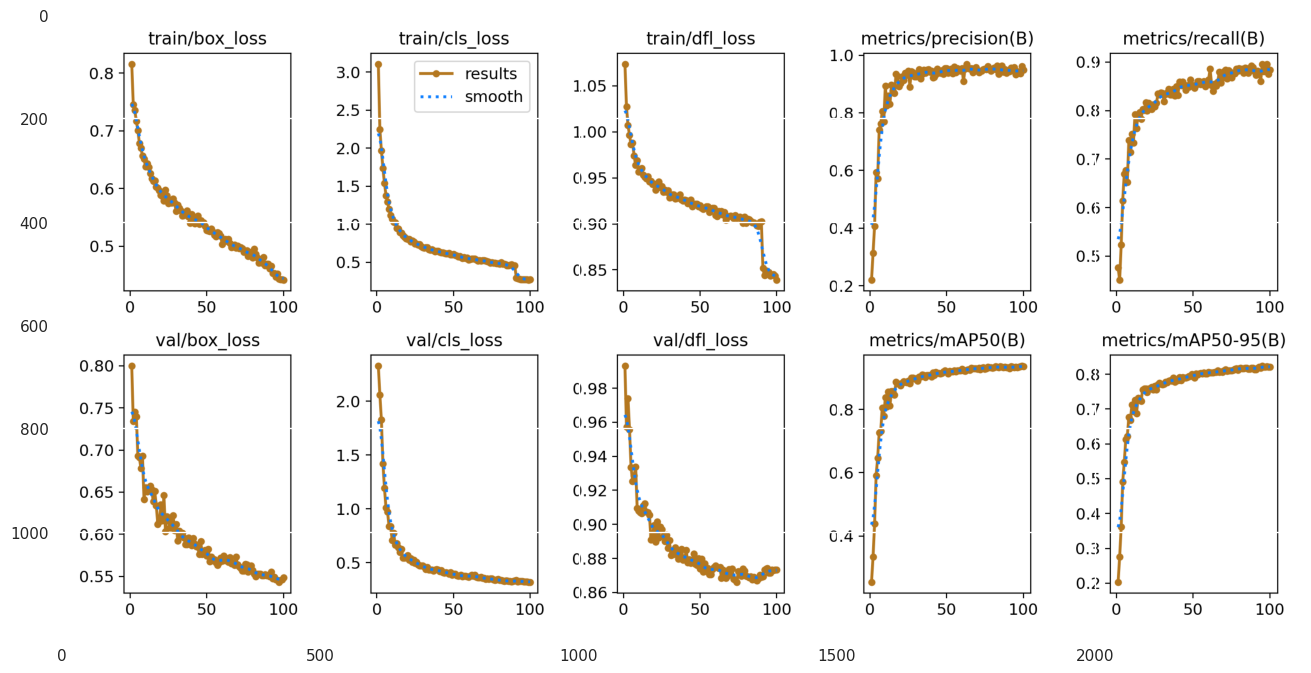

In [31]:
list_of_metrics = ["P_curve.png", "R_curve.png", "PR_curve.png", "F1_curve.png","confusion_matrix.png", "results.png"]
for i in list_of_metrics:
    
    image = cv2.imread(f'/kaggle/working/runs/detect/train4/{i}')
    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    plt.show()

#### Interpretation of the plots

1. **Precision-confidence Curve**: a graphical representation of how precision of the model changes at different confidence levels. In the first plot, we can see that the precisions of the model increases for all classes as the confidence increases. We are able to reach to precision score 1 for all classes when the confidence threshold is 0.958.

2. **Recall-confidence Curve**: a graphical representation of how recall of the model changes at different confidence levels. In the second plot, we can see that the recall of the model decreases for all classes as the confidence increases. The recall for all classes is 0.94 when the confidence threshold is 0.

3. **Precision-Recall Curve**: a graphical representation of the trade-off between precision and recall for different threshold used. From the third plot, we see that the model's precision decreases as the recall increases. When using IoU threshold (intersection over Union) of 0.5, the model is able to achieve mAP (mean average precision) of 0.908.

4. **F1-Confidence Curve**: a graphic representation of how F1 score of the model changes at different confidence levels. Since F1 score is caluclated using both precision and recall scores, it can be a good visualization of how the model is preforming overall. From the fourth plot, we can see that the F1 score increases and then decreases as the confidence threshold increases. When setting the confidence threshold as 0.319, we are able to achieve a F1 score of 0.88 for all classes. 

5. **Confusion Matrix**: a table that allows visualization of the performance of a classificaiotn model by summarizing the correct and incorrect classifications. The diagonal of the table shows all ture positives made by the model. As we can see from the fifth plot, most of high value numbers in the table are in the diagonal line, so we can conclude that the model is able to make correct prediction in most cases. 

6. **Results plot during training**: a combanation of different metrics measured during training process. In the sixth plot, we can see multiple visualization of different metrics values changes over different epochs. To better understand the results, we need to understand the different loss values measured first. 

box_loss: is also known as localication loss or regression loss. It measures the discrepancy between the predicted bounding box coordinates and the ground truth bounding box coordinates for each object in the image.

cls_loss: is konwn as classification loss. It measures the accuracy of the predicted class labels assigned to each bounding box.

dfl_loss: is known as domain-fused loss. It measures the discrepancy between feature representations learned by the model across different domains. The goal of minimizing dfl loss is to better align the feature representations across different domains, so that the model is able to improve the preformance in real-world scenarios where the testing data may differ from the training data. 

From the plots included in the sixth figure, we can see that all of those three loss values decreases and the precision and recall scores are increasing as more epoches trained. 

## Test the model on test data


image 1/1 /kaggle/input/cardetection/test/images/road652_png.rf.e82e3cfaed8d2378962fd6c1380f5d02.jpg: 416x416 1 Red Light, 1 Speed Limit 40, 1 Speed Limit 60, 6.7ms
Speed: 0.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/test/images/000288_jpg.rf.2764018cfc726e02916e1739c8f35b5e.jpg: 416x416 1 Speed Limit 40, 6.7ms
Speed: 0.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/test/images/road312_png.rf.ad2229fb2f7e136d7747b9568f121af4.jpg: 416x416 1 Speed Limit 40, 6.4ms
Speed: 0.7ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/test/images/road400_png.rf.03186a0125d7e8f9ccbad9322201c91a.jpg: 416x416 1 Speed Limit 100, 6.3ms
Speed: 0.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/test/im

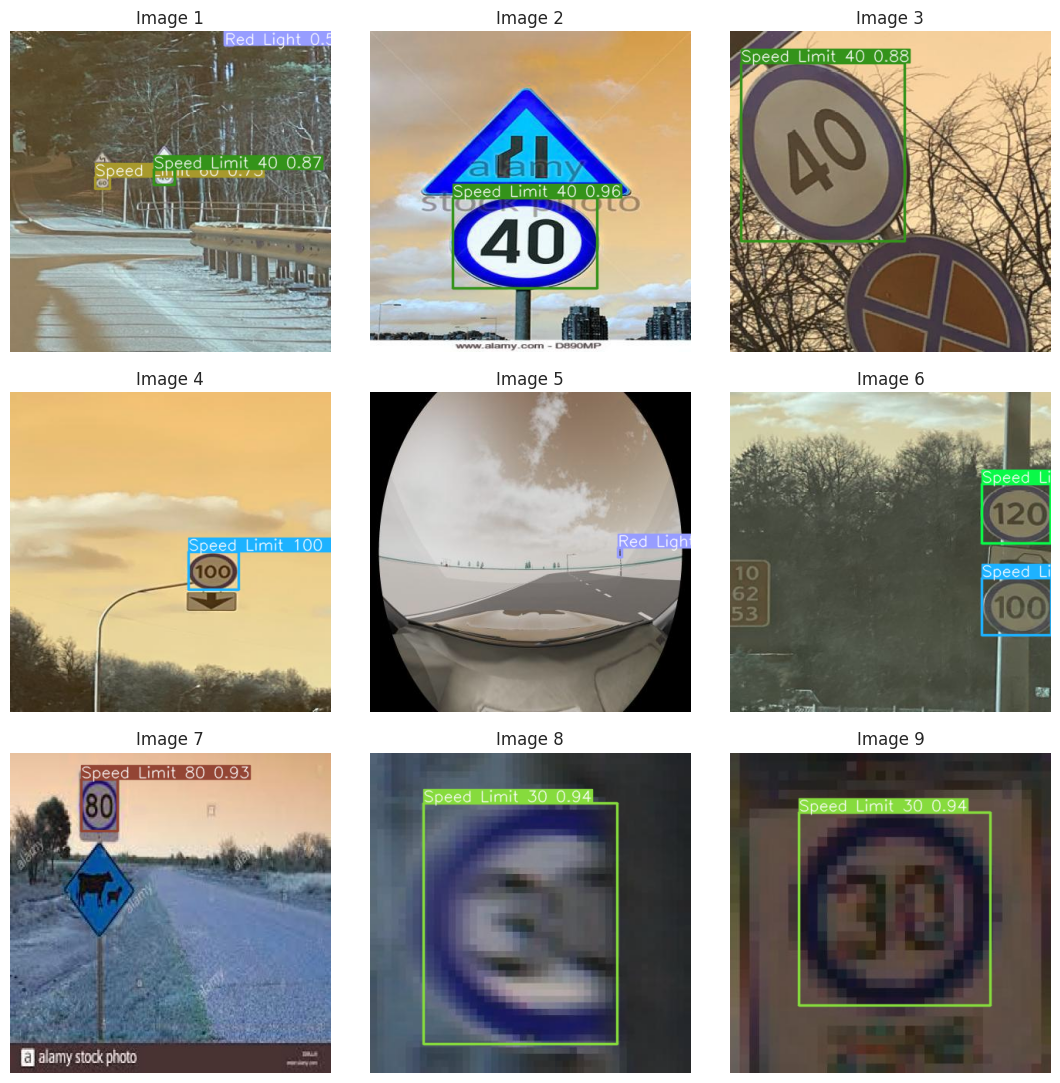

In [38]:
test_img_dir = '/kaggle/input/cardetection/test/images'
num_samples = 9
image_files = os.listdir(test_img_dir)
test_imgs = random.sample(image_files, num_samples)

final_model = YOLO("/kaggle/working/runs/detect/train4/weights/best.pt","v8")
fig, axes = plt.subplots(3,3, figsize = (11, 11))
for i in range(num_samples):
    image = test_imgs[i]
    ax = axes[i // 3, i%3]
    result_predict = final_model.predict(source = os.path.join(test_img_dir, image), imgsz = (416))
    ax.imshow(result_predict[0].plot())
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Based on the results obtained from the test images, we can see a significant performance increase from the pre-trained model. YOLOv8 has performed very well after training and can detect most objects that we specified in the dataset. 

## Conclusion

In this project, we utilized the YOLO model for traffic detection, starting with familiarization and testing of a pre-trained model. Then, we have fine-tuned the model with our dataset. The retrained model shows a significantly improved performance. We have also analyzed different metrics and plots obtained during the training process. All of those plots shows the confirmation of enhanced accuracy. 

### Current Limitation & Future work

- To improve the performance further, we could involve further optimization by adjusting parameters used in the YOLO model, for this project, I have only used default parameters mostly, but we can try out different parameter combinations to find the optional model to use. 

- During the analysis of the training results, we noticed that the model performance continue to increase in different metrics as number of epoches increase. So we can continue to train the model with more epoches, this should result in performance increase as well.

- Last but not least, the provided dataset only contains ~3.5K training images. If we can expand the training dataset further by including more samples, we could obtain a even better results. 


### Thank you!

If you found this notebook interesting, please give me a upvote! If you have any thoughts, I would love to hear it in the comments section! Thank you for reading!


image 1/1 /kaggle/input/cardetection/test/images/00000_00000_00008_png.rf.ff305dcd6e9ceb9188937311a4a1b207.jpg: 416x416 1 Speed Limit 20, 7.4ms
Speed: 0.9ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


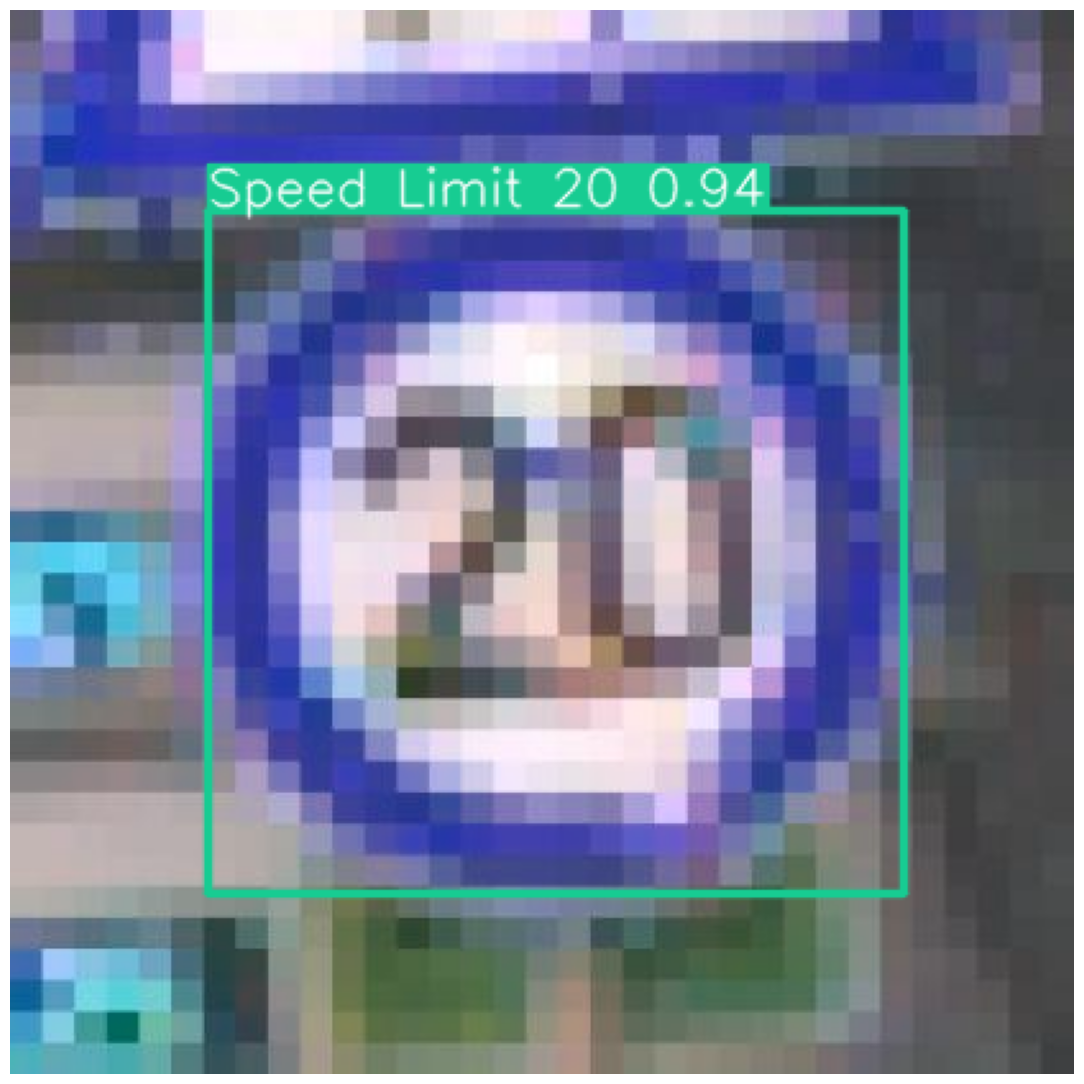

In [39]:
num_samples = 1
image_files = os.listdir(train_img_dir)
rand_imgs = random.sample(image_files, num_samples)

# Plotting setup for a single image
fig, ax = plt.subplots(figsize=(11, 11))

# Assuming this is the image path
image = "/kaggle/input/cardetection/test/images/00000_00000_00008_png.rf.ff305dcd6e9ceb9188937311a4a1b207.jpg"

# Predicting results using your final_model
result_predict = final_model.predict(source=image, imgsz=(416))

# Display the image with the prediction results
ax.imshow(result_predict[0].plot())
# ax.set_title(f'Image {i+1}')
ax.axis('off')

plt.tight_layout()
plt.show()